In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

In [3]:
BATCH_SIZE = 32
TARGET_SIZE = (250, 250)

In [4]:
# Walk through each directory
train_dir = "C:\\Users\\HP\\Desktop\\project\\Code\\RiceLeafsDisease\\train"
test_dir = "C:\\Users\\HP\\Desktop\\project\\Code\\RiceLeafsDisease\\validation"

In [5]:
image_dir = Path(train_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

### Reshaping dimensions so we can start processing arrays

In [27]:
img = plt.imread('RiceLeafsDisease/train/brown_spot/brown_spot (1).jpg')
dims = np.shape(img)
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

(2560000, 3)


Image shape ->  (1600, 1600)
Color channels ->  3
Min color depth : 0, Max color depth 255


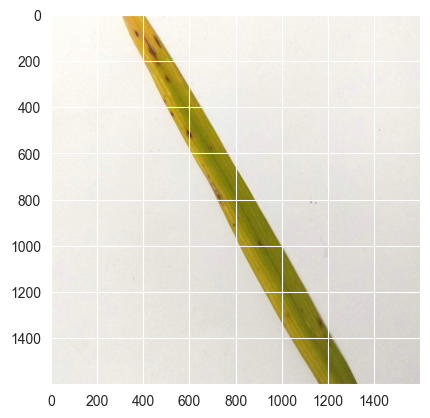

In [28]:
plt.imshow(img)
print("Image shape -> ",dims[:2])
print("Color channels -> ",dims[2])
print("Min color depth : {}, Max color depth {}".format(np.min(img),np.max(img)))

<span style=" font-family: Times New Roman ; font-size: 35px">
    Resize image </span>

In [ ]:
import glob
import cv2
import os

def resize_images(input_folder, output_folder, new_size):
 
    class_folders = glob.glob(os.path.join(input_folder, '*'))

    for class_folder in class_folders:
  
        image_files = glob.glob(os.path.join(class_folder, '*.*'))


        output_class_folder = os.path.join(output_folder, os.path.basename(class_folder))
        os.makedirs(output_class_folder, exist_ok=True)

  
        for img_path in image_files:
            try:
          
                image = cv2.imread(img_path)

        
                resized_image = cv2.resize(image, new_size)

    
                output_path = os.path.join(output_class_folder, os.path.basename(img_path))

                cv2.imwrite(output_path, resized_image)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

TRAIN_DIR  = "RiceLeafsDisease/training_1/"
VAL_DIR = "RiceLeafsDisease/evaluation_1/"
new_size = (250, 250)

resize_images(train_dir, TRAIN_DIR, new_size)
resize_images(test_dir, VAL_DIR, new_size)

<span style=" font-family: Times New Roman ; font-size: 35px">
    Data Visualization </span>

In [6]:
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
train_generator = train_generator.flow_from_directory(train_dir, target_size=TARGET_SIZE, shuffle=True, seed=41,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")

Found 1680 images belonging to 6 classes.


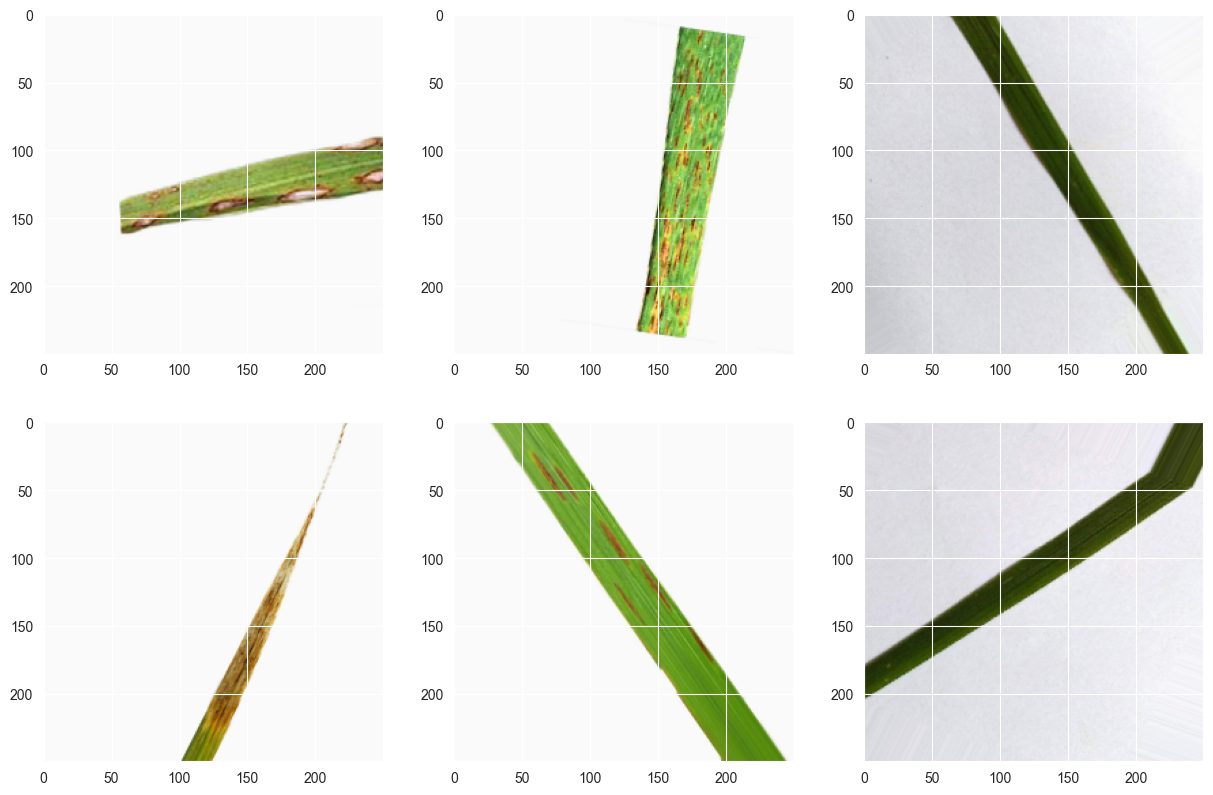

In [7]:
plt.figure(figsize=(15,15))
for i in range(6):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*250
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

### Classification

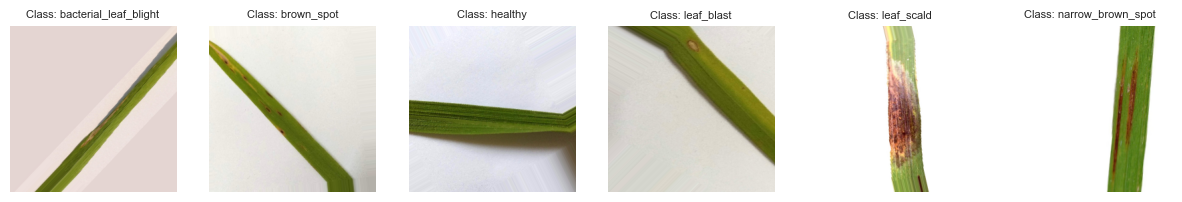

In [8]:
# obtain image and label list from train_generator
# Get category index
class_indices = train_generator.class_indices

# Initializes a dictionary to store the first graph for each category
first_images = {}

# Extract the first graph for each category
for class_name, class_index in class_indices.items():
    # Find the image index for this category
    train_generator.reset()  # Reset the generator to ensure you start from scratch
    found = False
    while not found:
        batch = next(train_generator)
        for index, label in enumerate(batch[1]):
            if label[class_index] == 1:
                first_images[class_name] = batch[0][index]
                found = True
                break


# Displays the first image for each category in a single row
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 3))  # Adjust figsize as needed

for i, (class_name, image) in enumerate(first_images.items()):
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}', fontsize=8)
    axes[i].axis('off')

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_16808\2654554033.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=sns.color_palette('hls', len(class_counts)))


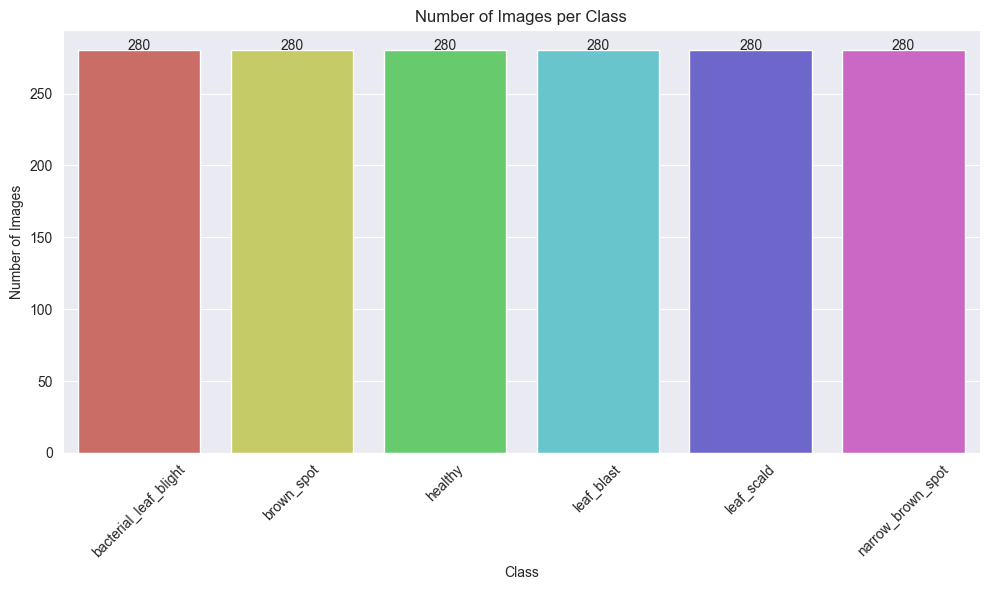

In [9]:
import seaborn as sns

labels = train_generator.classes

class_names = list(train_generator.class_indices.keys())  
  
# 计算每个类别的图像数量  
class_counts = {class_name: np.sum(labels == i) for i, class_name in enumerate(class_names)}  
  
# 绘制直方图  
plt.figure(figsize=(10, 6))  
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=sns.color_palette('hls', len(class_counts)))  

for i, v in enumerate(class_counts.values()):  
    plt.text(i, v + 0.1, str(v), ha='center') 
  
plt.xlabel('Class')  
plt.ylabel('Number of Images')  
plt.title('Number of Images per Class')  
plt.xticks(rotation=45)  # 旋转x轴标签以便更好地显示  
plt.tight_layout()  # 确保标签不会与条形重叠  
plt.show()

### Plot for visualizing pixel intensities for RGB in color space

C:\Users\HP\AppData\Local\Temp\ipykernel_17756\518663470.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
C:\Users\HP\AppData\Local\Temp\ipykernel_17756\518663470.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(matrix[:,1], bins=2

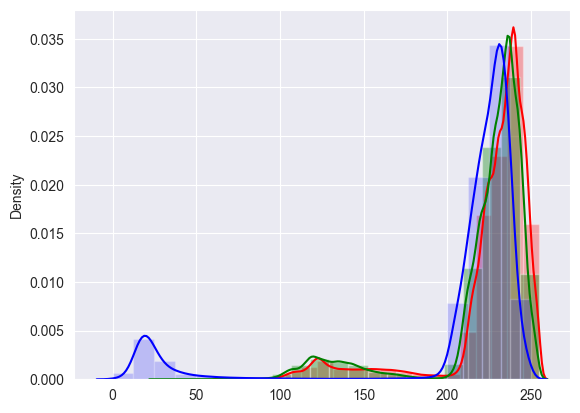

In [29]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

### Plot for visualizing histogram between 2 color channel

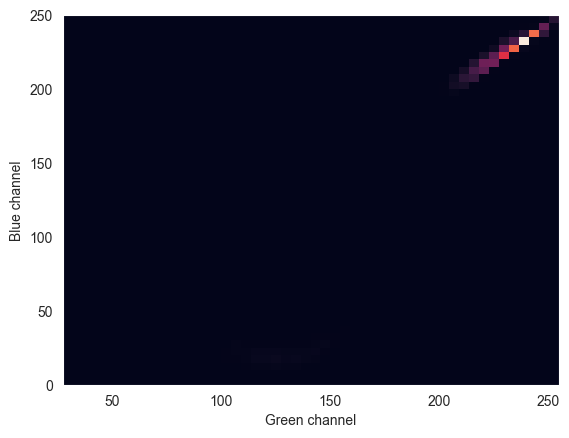

In [30]:
_ = plt.hist2d(matrix[:,1], matrix[:,2], bins=(50,50))
plt.xlabel('Green channel')
plt.ylabel('Blue channel')
plt.show()

The pixels between green and blue bands are correlated (as evident from overlapping on above graph), and typically has visible imagery.

Raw band differences will need to be scaled or thresholded

Image data consists of variations due to resolution differences between scenes, pixel intensities of an image and the environment around which the image was taken. This area of image processing is critical in today's time with the rise of Artificial intelligence.From motion detection to complex circuits in self driving car, the research requires tremendous amount of work and can be seen as widely growing areas of computer vision.

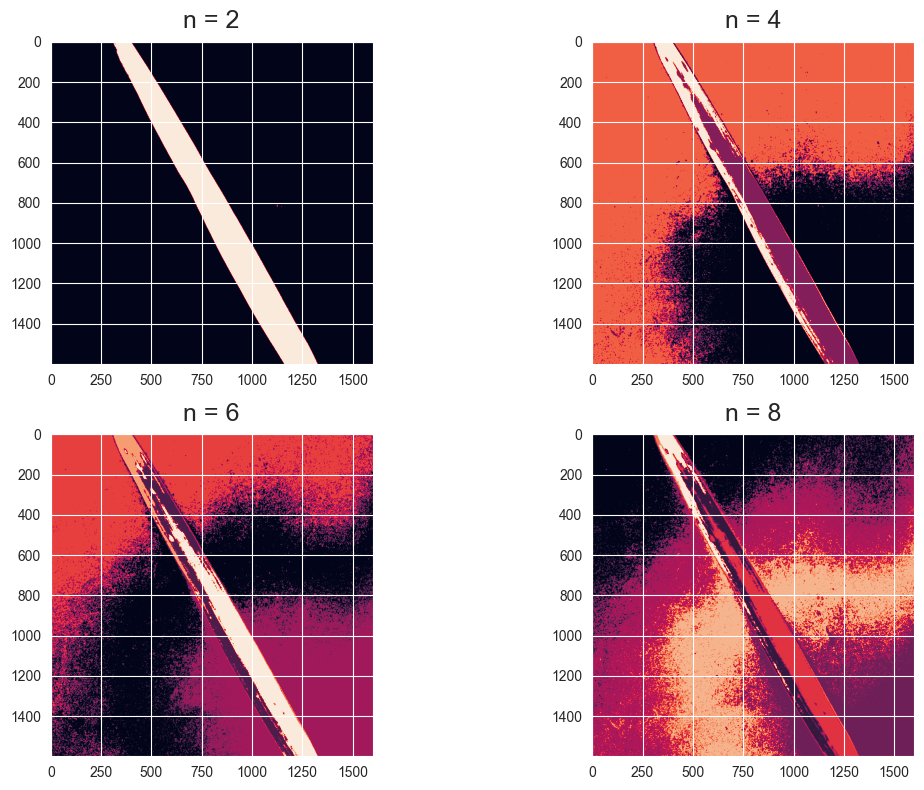

In [31]:
from sklearn import cluster
n_vals=[2,4,6,8]
plt.figure(1, figsize=(12, 8))

for subplot,n in enumerate(n_vals):
    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n), pad = 10,size=18)
    plt.imshow(clustered_img)
    
plt.tight_layout()

### Let's visualize the channel intensity for every cluster we just generated

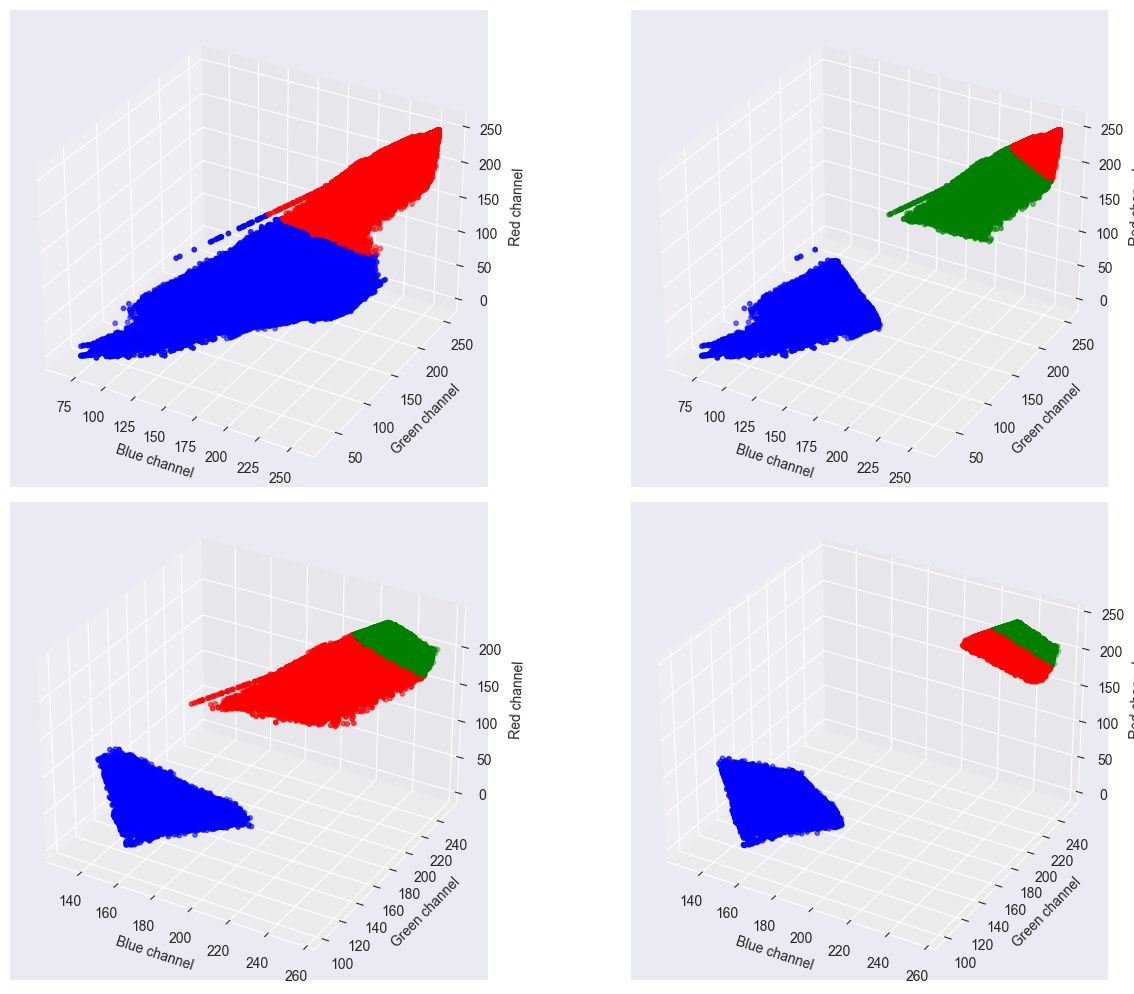

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(14,10))

ax = [fig.add_subplot(221, projection='3d'),
      fig.add_subplot(222, projection='3d'),
      fig.add_subplot(223, projection='3d'),
      fig.add_subplot(224, projection='3d')]

for plot_number,n in enumerate(n_vals):
    
    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    x1, y1, z1 = [np.where(clustered == x)[0] for x in [0, 1, 2]]

    plot_vals = [('r', x1),
                 ('b', y1),
                 ('g', z1),
                 ]
    
    for c, channel in plot_vals:
        x = matrix[channel, 0]
        y = matrix[channel, 1]
        z = matrix[channel, 2]
        ax[plot_number].scatter(x, y, z, c=c,s=10)
    
    ax[plot_number].set_xlabel('Blue channel')
    ax[plot_number].set_ylabel('Green channel')
    ax[plot_number].set_zlabel('Red channel')

plt.tight_layout()

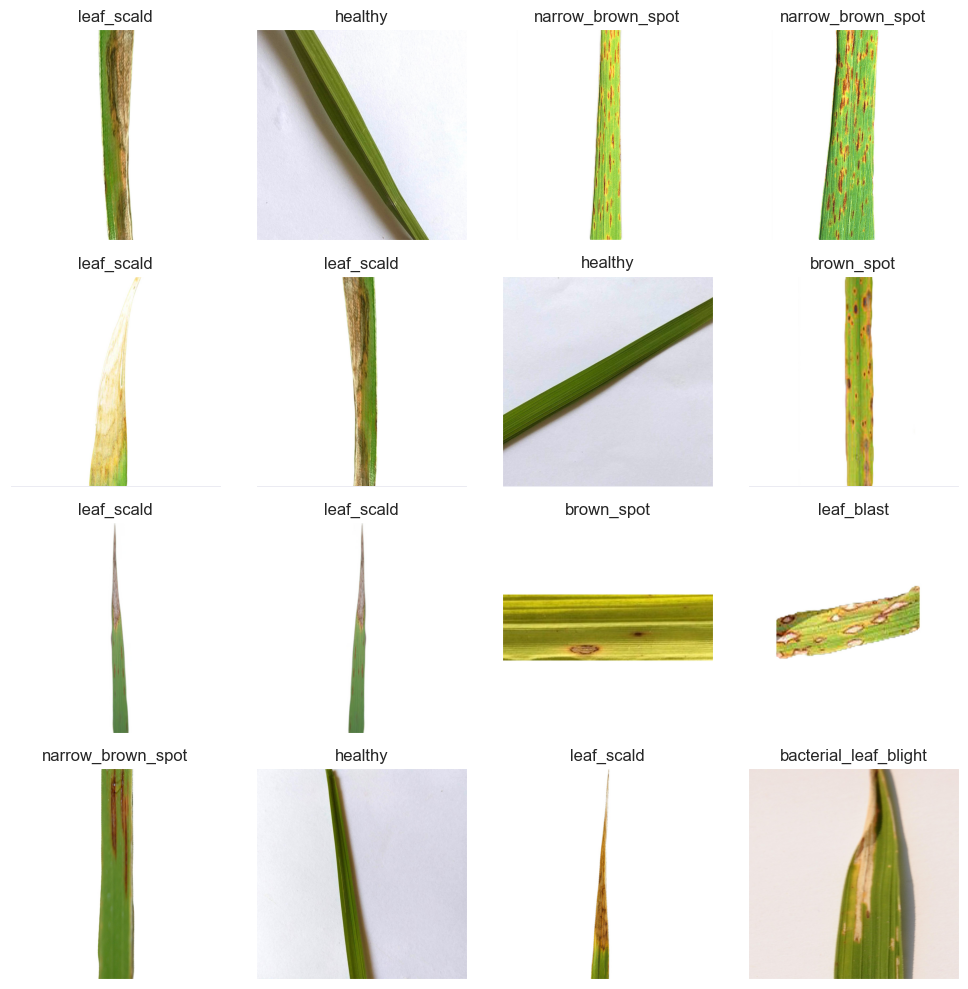

In [19]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [20]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

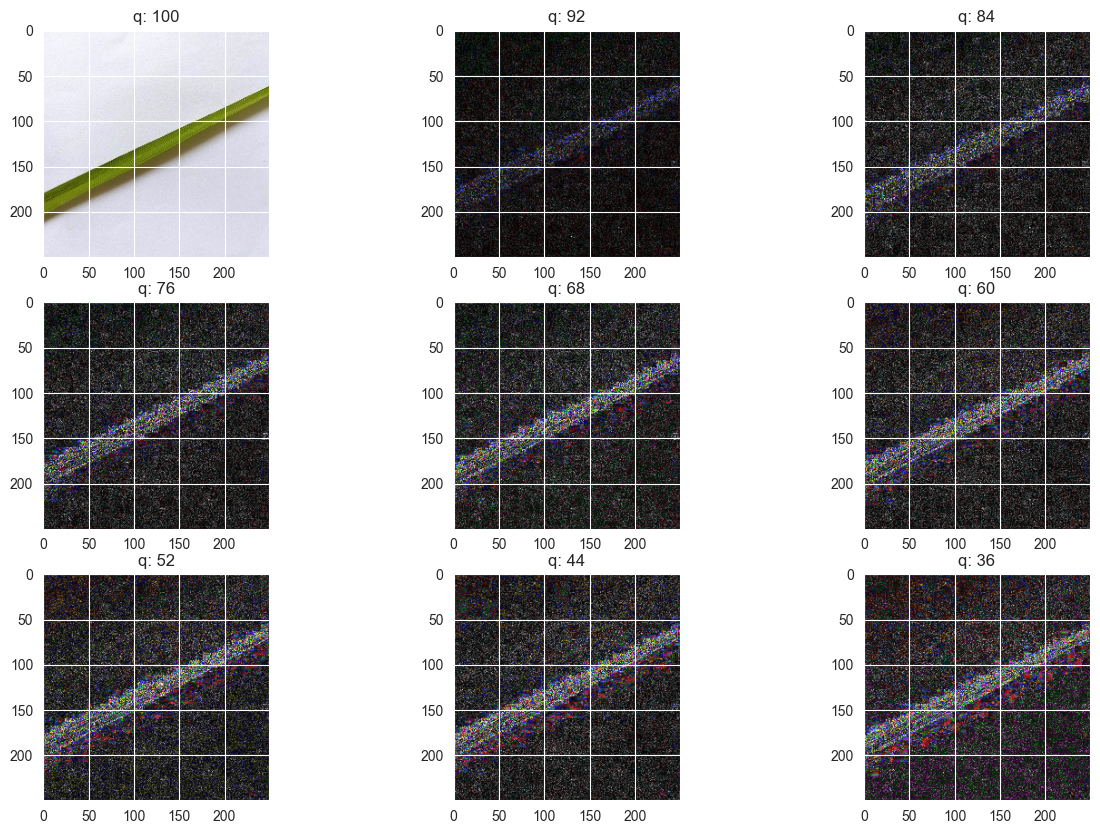

In [26]:
# View random sample from the dataset
p = random_sample('RiceLeafsDisease/training_1/healthy')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

## Visualising Kernels

In [ ]:
fig, ax= plt.subplots(3,4, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]
  ax.imshow(kernel1_1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off');

In [ ]:
image = tf.keras.utils.load_img('rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0112.jpg', target_size=(250,250))
input_arr = tf.keras.utils.img_to_array(image)/255
image = input_arr[:, :, 1]
plt.imshow(image)
plt.axis('off')

In [ ]:
def convolution(image, kernel):
    # Get the size of the kernel
    kernel_size = kernel.shape[0]

    # Calculate the size of the output image
    output_size = image.shape[0] - kernel_size + 1

    # Initialize the output image
    output_image = np.zeros((output_size, output_size))

    # Pad the image with zeros
    padded_image = np.pad(image, ((kernel_size-1)//2, (kernel_size-1)//2), 'constant')

    # Apply the convolution operation
    for ii in range(output_size):
        for jj in range(output_size):
            window = padded_image[ii:ii+kernel_size, jj:jj+kernel_size]
            output_image[ii, jj] = np.sum(window * kernel)

    return output_image

In [ ]:
fig, ax= plt.subplots(3,4, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]

  output=convolution(image, kernel1_1)

  ax.imshow(output)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off')

### MODEL LAYERS

In [ ]:
print("Total layers in the model : ",len(model.layers),"\n")

# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)
# print(layers)

layer_names = []
for layer in model.layers[1:11]: 
    layer_names.append(layer.name)
    
print("First 10 layers which we can visualize are -> ", layer_names)

### LAYER WISE ACTIVATIONS

In [ ]:
from tensorflow.keras.preprocessing import image

def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(250, 250))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    plt.imshow(img[0])
    plt.show()
    return model_activations.predict(img)

def show_activations(activations, layer_names):
    
    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :,col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

In [ ]:
RiceLeaf = 'RiceLeafsDisease/train/brown_spot/brown_spot (1).jpg'
activations = get_activations(RiceLeaf,activations_output)
show_activations(activations, layer_names)

In [ ]:
def activation_conv():
    first_convlayer_activation = activations[0]
    second_convlayer_activation = activations[3]
    third_convlayer_activation = activations[6]
    f,ax = plt.subplots(1,3, figsize=(10,10))
    ax[0].imshow(first_convlayer_activation[0, :, :, 3], cmap='viridis')
    ax[0].axis('OFF')
    ax[0].set_title('Conv2d_1')
    ax[1].imshow(second_convlayer_activation[0, :, :, 3], cmap='viridis')
    ax[1].axis('OFF')
    ax[1].set_title('Conv2d_2')
    ax[2].imshow(third_convlayer_activation[0, :, :, 3], cmap='viridis')
    ax[2].axis('OFF')
    ax[2].set_title('Conv2d_3')

In [ ]:
activation_conv()

## HEATMAPS

In [ ]:
import tensorflow.keras.backend as K

def get_attribution(RiceLeaf):
    
    tf.compat.v1.disable_eager_execution()
    
    img = image.load_img(RiceLeaf, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0)
    model = load_model('model_v1_inceptionV3.h5')
        
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(RiceLeaf)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

In [ ]:
pred = get_attribution('RiceLeafsDisease/validation/leaf_blast/leaf_blast_val (1).jpg')

## Grad-Cam Visualization
Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction.  It allows you to see which regions of the image the model focused on while making its prediction.  Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {y_pred[random_index[i]]}")
plt.tight_layout()
plt.show()

## Lime
LIME(Local Interpretable Model-agnostic Explanation) to generate local intepretations of black box models
LIME stands for Local Interpretable Model-Agnostic Explanations.  We can use it with any model we've built in order to explain why it took a specific decision for a given observation.  To do so, LIME creates a dataset in the locality of our observation by perturbating the different features.  Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

In [ ]:
from lime.lime_image import LimeImageExplainer

In [ ]:
#function of keras, allows to see the prob of each prediction
decode_predictions(y_pred)

In [ ]:
# extract the index of the top 5 classes predicted by the model for the image selected 
model.predict(image).argsort()[0, -5:][::-1]

#keep the index of the first and the second class 
first_class = model.predict(image).argsort()[0, -5:][-1]
second_class = model.predict(image).argsort()[0, -5:][-2]

In [ ]:
explainer = LimeImageExplainer()

explanation = explainer.explain_instance(image[0], #the image
                                         model.predict, 
                                         top_labels=6, #want just to see the 6 main classes predicted
                                         num_samples=500, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

In [ ]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

get_image_and_mask()允许获取和绘制映射。
要解释的类的索引(我们之前发现的)

positive_only:为了显示图像中对被选中的类有积极贡献的部分

Num_features:要使用的超像素数量。LIME将我们的图像分解成一组超像素，每个超像素包含几个像素。这些超像素相当于表格数据中的特征。

Hide_rest:隐藏图像的其余部分

它以numpy数组的形式返回一个新图像和一个掩码。然后，您可以使用mark_boundaries来显示图像和蒙版。

In [ ]:
# maps for the first class predicted
temp, mask = explanation.get_image_and_mask(first_class, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print('mask for prediction of class: ',decode_predictions(y_pred)[0][0][1])

In [ ]:
# maps for the second class predicted 
temp, mask = explanation.get_image_and_mask(second_class, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print('mask for prediction of class: ', decode_predictions(y_pred)[0][1][1])

## SHAP
SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

It interprets the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value (e.g. zero)

In [ ]:
import shap
train_cases = ['ok_front/'+i for i in os.listdir(f'{train_generter}/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/ok_front')]
train_cases.extend(['def_front/'+i for i in os.listdir(f'{data_dir}/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front')])
train_sample = [cv2.imread(train_path + i, cv2.IMREAD_GRAYSCALE).reshape(1, *(250,250,3)) / 255 for i in np.random.choice(train_cases, 3000, replace=False)]
explainer = shap.DeepExplainer(model, train_sample[0])

In [ ]:
test_cases = ['def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']

for i in test_cases:
    img = cv2.imread(test_path + i, cv2.IMREAD_GRAYSCALE).reshape(1, *(250,250,3)) / 255
    shap_values = explainer.shap_values(img)
    shap.image_plot(shap_values, img, show=False) 
    plt.title(f"{i.split('/')[1]}\n Actual Label : {i.split('_')[0]}", weight='bold', size=12)
    plt.axis('off')
plt.show()